In [1]:
import math
import numpy as np
import ceo
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
nLenslet = 1
n = 401
nPx = n*nLenslet+1
D = 25.5
n_radius = nPx
#onAxis = ceo.Source("R",zenith=0.*math.pi/180/3600,azimuth=0*math.pi/4,
#                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,-25])
src    = ceo.Source("J",zenith=np.array([8,8,8])*ceo.constants.ARCMIN2RAD,
                    azimuth=np.array([0,120,240])*math.pi/180,
                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
GMT = ceo.GMT_MX(D,nPx)
wfs = ceo.ShackHartmann(1,nPx-1,D,N_PX_IMAGE=nPx)

In [3]:
GMT.M1.motion_CS.origin[0,2] = -1e-6
GMT.M1.motion_CS.origin[3,2] = -1e-6
GMT.M1.motion_CS.origin[1,2] = 0.5e-6
GMT.M1.motion_CS.origin[5,2] = -0.5e-6
GMT.M1.motion_CS.origin[4,2] = 0.5e-6
GMT.M1.motion_CS.origin[2,2] = -0.5e-6
GMT.M1.motion_CS.origin[6,2] = 1e-6
GMT.M1.motion_CS.update()

In [4]:
GMT.propagate(src)

In [5]:
sps = ceo.SegmentPistonSensor(GMT.M1,src)

In [19]:
src.magnitude = 10
sps.camera.reset()
sps.propagate(src)

<matplotlib.colorbar.Colorbar instance at 0x2b5791601128>

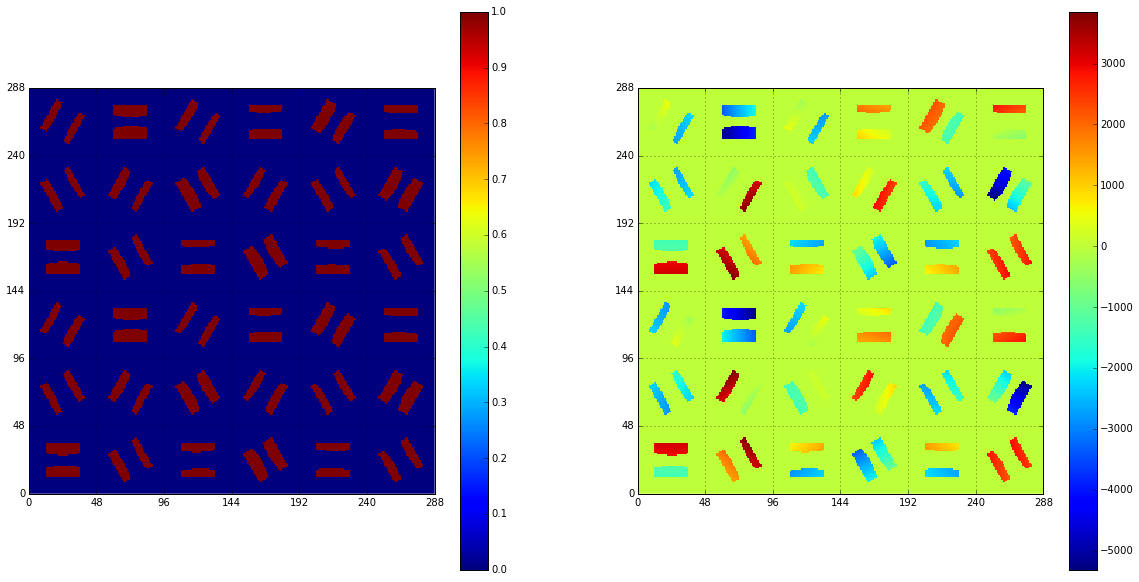

In [20]:
fig, (ax1,ax2) = subplots(ncols=2)
fig.set_size_inches((20,10))
h1 = ax1.imshow(sps.W.amplitude.host(),
               interpolation='None',extent=[0,288,0,288],
               origin='lower')
ax1.set_xticks(np.arange(0,48*7, 48))
ax1.set_yticks(np.arange(0,48*7, 48))
ax1.grid()
colorbar(h1,ax=ax1)
h2 = ax2.imshow(sps.W.phase.host(units='nm'),
               interpolation='None',extent=[0,288,0,288],
               origin='lower')
ax2.set_xticks(np.arange(0,48*7, 48))
ax2.set_yticks(np.arange(0,48*7, 48))
ax2.grid()
colorbar(h2,ax=ax2)

<matplotlib.colorbar.Colorbar instance at 0x2b579183f830>

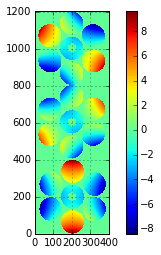

In [21]:
imshow(src.phase.host(units='micron'),interpolation='None',origin='lower')
grid()
colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2b57919a0f80>

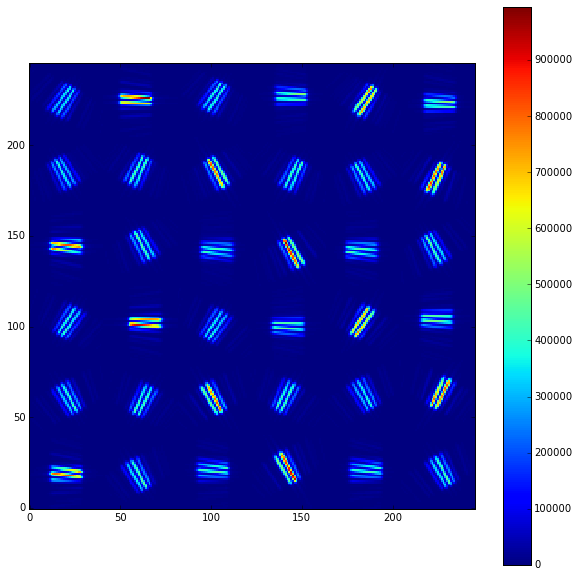

In [22]:
fig, ax1 = subplots()
fig.set_size_inches((10,10))
imshow(sps.camera.frame.host(),interpolation='None',origin='lower')
colorbar()